[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lucasavila00/filtroume/blob/master/tf/all.ipynb)

**WARNING:**

This is my first ML project.

I'm not so sure if what I did was *correct* but the approach of this notebook worked on real life and solved my problem.

## Setup & Imports
If Tensorflow Graphics is not installed on your system, the following cell can install the Tensorflow Graphics package for you.

In [1]:
!pip install tensorflow_graphics

     |████████████████████████████████| 245kB 48.6MB/s 


Now that Tensorflow Graphics is installed, let's import everything needed to run the demos contained in this notebook.

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_graphics as tfg
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow_graphics.geometry.transformation import quaternion
from tensorflow_graphics.math import vector
from tensorflow_graphics.notebooks import threejs_visualization
from tensorflow_graphics.notebooks.resources import tfg_simplified_logo


import sys
module = sys.modules['tensorflow_graphics.util.shape']
def _get_dim(tensor, axis):
  """Returns dimensionality of a tensor for a given axis."""
  return tf.compat.v1.dimension_value(tensor.shape[axis])

module._get_dim = _get_dim

sys.modules['tensorflow_graphics.util.shape'] = module

# Load the TensorBoard notebook extension
%load_ext tensorboard

TensorFlow 2.x selected.


Now lets define our 3D points for data generation.

In [0]:
vertices = np.array(
  [
    [-3.23597, 3.23021, -3.33562],
    [3.23597, 3.23021, -3.33562],
    [0, 0.003874, 0.290468],
    [0, -3.53483, -2.08927],
    [-8.04888, 2.22486, -12.6444],
    [8.04888, 2.22486, -12.6444],
  ],
  dtype="float32"
)

num_vertices = vertices.shape[0]

# Data generation and pre-processing

We project the 3d points onto a 2D plane.
An approximated focal point and projection centeris used and it won't interfere too much with results.

In [0]:
def generate_training_data(num_samples, s):
  # random_angles.shape: (num_samples, 3)
  random_angles = np.random.uniform([[-np.pi/3,-np.pi/3,-np.pi/3]], [[np.pi/3,np.pi/3,np.pi/3]],
                                    (num_samples, 3)).astype(np.float32)

  # random_quaternion.shape: (num_samples, 4)
  random_quaternion = quaternion.from_euler(random_angles)

  # I'm using this scale factor so that I can generate different sets for training and testing
  # and different scales. This helped me a lot to identify early on whether the model was overfitting
  # or really learning.
  # random_translation.shape: (num_samples, 3)
  random_translation = np.random.uniform([[-40.0 *s,-40.0*s,-40.0*s]], [[40.0*s, 40.0*s, 1.0*s]],
                                        (num_samples, 3)).astype(np.float32)

  # data.shape : (num_samples, num_vertices, 3)
  data = quaternion.rotate(vertices[tf.newaxis, :, :],
                          random_quaternion[:, tf.newaxis, :]
                          ) + random_translation[:, tf.newaxis, :]

  # now lets project our points in the 2D plane
  data = tfg.rendering.camera.perspective.project(
      data + np.random.uniform(-1,1,(num_samples, num_vertices, 3)), # add noise
      [1.0, 1.0], # focal point
      [0.5, 0.5], # projection center
  )

  # since the projection 'inverts' the coords lets invert them again
  
  data = 1 - data
  
  # target.shape : (num_samples, 4+3)
  target = tf.concat((random_quaternion, random_translation), axis=-1)

  data = np.array(data)
  target = np.array(target)
  # ret = ( np.array(data), np.array(target) )

  xs = []
  ys = []

  for i in range(len(data)):
    # even tough the model will only be used with values between 0 and 1
    # clipping values right at the end made the model bad at screen corners
    # on my real life tests.
    # Allowing it to be a little bigger or smaller made results better.
    if np.max(data[i]) < 1.1 and np.min(data[i]) > -0.1:
      xs.append(data[i])
      ys.append(target[i])

  return np.array(xs), np.array(ys)

Let's test our data generation.
We will generate a few samples and print them.

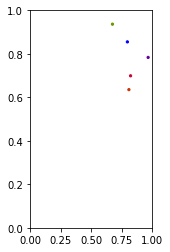

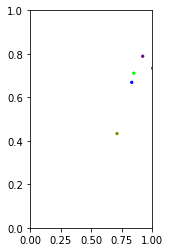

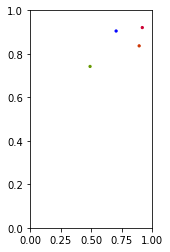

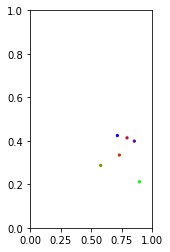

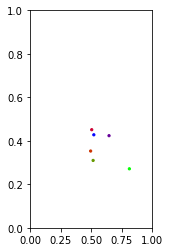

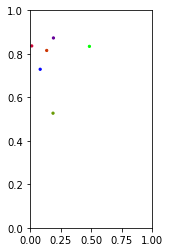

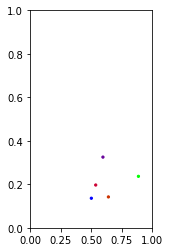

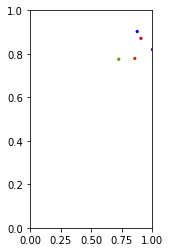

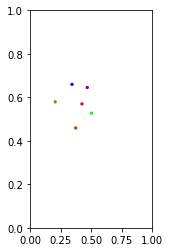

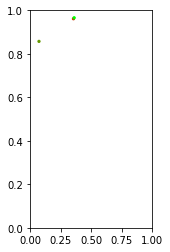

In [9]:
def print_20points_image(points):
  fig1, ax1 = plt.subplots()
  # we use one color for each point
  plt.scatter(points[:,0], points[:,1], s=5, c=[0,1,2,3,4,5], cmap="brg")
  ax1.set_aspect(16/9)
  plt.ylim([0,1])
  plt.xlim([0,1])
  plt.show()

to_print_data, to_print_target = generate_training_data(100, 1)
for x in to_print_data:
  print_20points_image(x)

And it doesn't look that good. I wouldn't be able to say what cursed parameters led to these bad results...

**But don't worry, these will make sure that on real life (where noise will be a real thing) it works.**

Now let's generate the real data.
Note that I'm using 1M projections but in the end, after being filtered to see if they got projected to the screen it will give me back 10% to 2% of this value, depending on the desired scale.

We also print mean and scale after fitting the data.
This should be used after inference to scale the data back to usable state.

In [10]:
from sklearn import preprocessing
num_samples = 1000*1000

data, target_raw = generate_training_data(num_samples, 2.0)
print(data.shape)   # (num_samples, num_vertices, 3): the vertices

scaler = preprocessing.StandardScaler().fit(target_raw)

print("mean:")
print(scaler.mean_)


print("scale:")
print(scaler.scale_)

target = scaler.transform(target_raw)
print(target.shape)  # (num_samples, 4+3): the quaternion and translation

data_test, target_test_raw = generate_training_data(int(num_samples / 4), 1.0)
target_test = scaler.transform(target_test_raw)
print(data_test.shape)   # (num_samples, num_vertices, 3): the vertices

(89262, 6, 2)
mean:
[-7.08806138e-03 -1.44241489e-03  2.81328166e-04  8.74965640e-01
  6.67847506e-02 -5.86922866e-01 -6.17359176e+01]
scale:
[ 0.2757907   0.27300393  0.2815135   0.06738858 19.90217464 20.18727223
 14.15780724]
(89262, 7)
(16776, 6, 2)


In [0]:
# This commented code is used to load an image and the image points of that image
# for debugging inside colab. Then this image and projection cloud be passed to
# print_20points_image_dbg and print_debug_image functions.

# import matplotlib.image as mpimg

# from google.colab import files

# uploaded = files.upload()

# console.log() the points in JS and paste them here, for instance...
# me_projected = np.array(
#   [[0.4350360035896301,0.2992444960400462],[0.6202644556760788,0.2890130840241909],[0.5242814123630524,0.43495921790599823],[0.5284686274826527,0.5079091489315033],[0.34651653468608856,0.29937793873250484],[0.712720975279808,0.2856548335403204]]
# )

# me_photo = mpimg.imread('my_photo.png')


# lets create some functions that allow us to visualize the data that the NN gets
# and how it will become after being reprojected
def transform_points(target_points, quaternion_variable, translation_variable):
  x = quaternion.rotate(target_points,
                           quaternion_variable) + translation_variable


  return x

def print_20points_image_dbg(points, img=None):
  fig1, ax1 = plt.subplots()
  plt.scatter(points[:,0], points[:,1], s=5, c=[0,1,2,3,4,5], cmap="brg")
  ax1.set_aspect(16/9)
  if img != None:
    ax1.imshow(img, extent=[0, 1, 1, 0])
  plt.ylim([0,1])
  plt.xlim([0,1])
  plt.show()
# print_20points_image_dbg(_test_proj)

In [0]:
def rnd_img():
  while True:
    to_print_data, to_print_target = generate_training_data(100, 1)
    for x in to_print_data:
      return x

def print_debug_image(proj, img=None):
  res = model.predict(np.array([proj]))[0]
  den = scaler.inverse_transform(res)
  initial_orientation = transform_points(vertices, den[0:4],
                                       den[4:7]).numpy()


  reprojected = 1 - tfg.rendering.camera.perspective.project(
        initial_orientation,
        [1.0, 1.0],
        [0.5, 0.5],
    )
  print_20points_image_dbg(proj, img)
  print_20points_image_dbg(reprojected, img)


In [13]:
tf.keras.backend.set_floatx("float32")

# KISS :)
# Anything more complicated than this and overfitting happens.
model = keras.Sequential()
model.add(layers.Flatten(input_shape=(num_vertices, 2)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(7))

# We use 3D reprojection error
def pose_estimation_loss(y_true, y_pred):
  # y_true.shape : (batch, 7)
  y_true_q, y_true_tn = tf.split(y_true* scaler.scale_ + scaler.mean_, (4, 3), axis=-1)
  # y_pred.shape : (batch, 7)
  y_pred_q, y_pred_tn = tf.split(y_pred* scaler.scale_ + scaler.mean_, (4, 3), axis=-1)

  y_true_t = y_true_tn 
  y_pred_t = y_pred_tn 
  # vertices.shape: (num_vertices, 3)
  # corners.shape:(num_vertices, 1, 3)
  corners = tf.expand_dims(vertices, axis=1)

  # transformed_corners.shape: (num_vertices, batch, 3)
  # q and t shapes get pre-pre-padded with 1's following standard broadcast rules.
  transformed_corners = quaternion.rotate(corners, y_pred_q) + y_pred_t

  # recovered_corners.shape: (num_vertices, batch, 3)
  recovered_corners = quaternion.rotate(transformed_corners - y_true_t,
                                        quaternion.inverse(y_true_q))

  # vertex_error.shape: (num_vertices, batch)

  # I found that by using the abs error will prevent the NN from underestimating
  # the scale of the images (on real life).
  vertex_error = tf.reduce_sum(tf.math.abs(recovered_corners - corners), axis=-1)
  # vertex_error = tf.reduce_sum((recovered_corners - corners)**2, axis=-1)

  return tf.reduce_mean(vertex_error)

model.compile(loss=pose_estimation_loss,
              metrics=["mae","mse"],
              optimizer="adam"
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                832       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 455       
Total params: 5,447
Trainable params: 5,447
Non-trainable params: 0
_________________________________________________________________


# Training

At this point, everything is in place to start training the neural network!

In [0]:
# Callback allowing to display the progression of the training task.
class ProgressTracker(keras.callbacks.Callback):

  def __init__(self, num_epochs, step=5):
    self.num_epochs = num_epochs
    self.current_epoch = 0.
    self.step = step
    self.last_percentage_report = 0

  def on_epoch_end(self, batch, logs={}):
    print_debug_image(rnd_img())
    self.current_epoch += 1.
    training_percentage = int(self.current_epoch * 100.0 / self.num_epochs)
    if training_percentage - self.last_percentage_report >= self.step:
      print('Training ' + str(
          training_percentage) + '% complete. Training loss: ' + str(
              logs.get('loss')) + ' | Validation loss: ' + str(
                  logs.get('val_loss')))
      self.last_percentage_report = training_percentage

Train on 89262 samples, validate on 16776 samples
Epoch 1/50


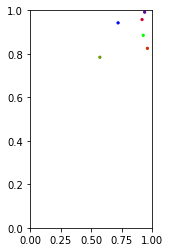

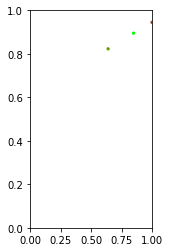

89262/89262 - 23s - loss: 14.1355 - mae: 0.5095 - mse: 0.5067 - val_loss: 9.1351 - val_mae: 0.3350 - val_mse: 0.2529
Epoch 2/50


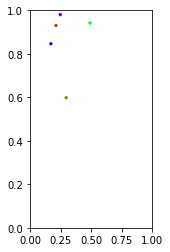

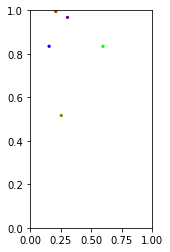

89262/89262 - 19s - loss: 6.9988 - mae: 0.2846 - mse: 0.2140 - val_loss: 6.1000 - val_mae: 0.2516 - val_mse: 0.1685
Epoch 3/50


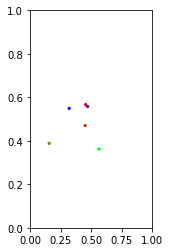

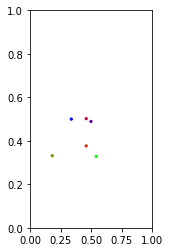

Training 6% complete. Training loss: 5.995168959701014 | Validation loss: 5.118224129656354
89262/89262 - 20s - loss: 5.9952 - mae: 0.2396 - mse: 0.1667 - val_loss: 5.1182 - val_mae: 0.2270 - val_mse: 0.1423
Epoch 4/50


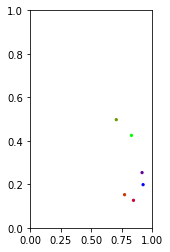

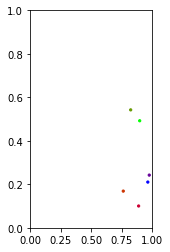

89262/89262 - 20s - loss: 5.5719 - mae: 0.2193 - mse: 0.1438 - val_loss: 4.2850 - val_mae: 0.2061 - val_mse: 0.1211
Epoch 5/50


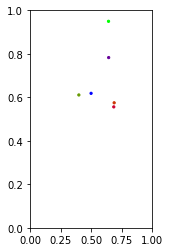

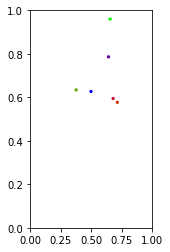

89262/89262 - 19s - loss: 5.3226 - mae: 0.2056 - mse: 0.1273 - val_loss: 4.1308 - val_mae: 0.1932 - val_mse: 0.1046
Epoch 6/50


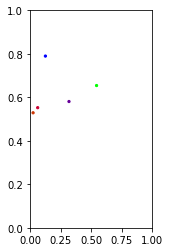

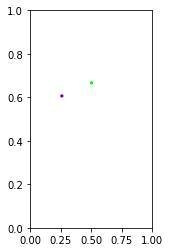

Training 12% complete. Training loss: 5.15718713453831 | Validation loss: 4.20994475232344
89262/89262 - 20s - loss: 5.1572 - mae: 0.1960 - mse: 0.1152 - val_loss: 4.2099 - val_mae: 0.1853 - val_mse: 0.0935
Epoch 7/50


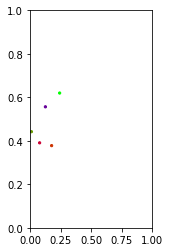

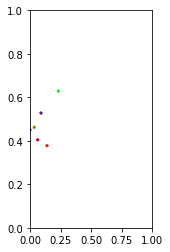

89262/89262 - 19s - loss: 5.0413 - mae: 0.1877 - mse: 0.1043 - val_loss: 3.8909 - val_mae: 0.1806 - val_mse: 0.0867
Epoch 8/50


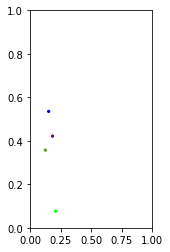

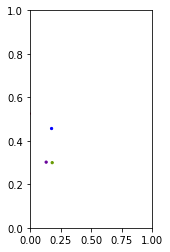

89262/89262 - 19s - loss: 4.9528 - mae: 0.1807 - mse: 0.0957 - val_loss: 4.6092 - val_mae: 0.1786 - val_mse: 0.0799
Epoch 9/50


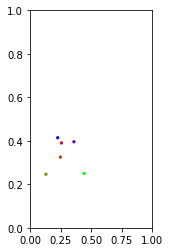

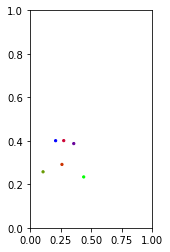

Training 18% complete. Training loss: 4.871050119116899 | Validation loss: 3.9967825110321336
89262/89262 - 19s - loss: 4.8711 - mae: 0.1745 - mse: 0.0882 - val_loss: 3.9968 - val_mae: 0.1709 - val_mse: 0.0777
Epoch 10/50


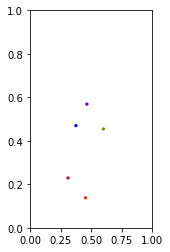

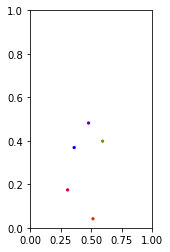

89262/89262 - 19s - loss: 4.8373 - mae: 0.1701 - mse: 0.0825 - val_loss: 3.8583 - val_mae: 0.1717 - val_mse: 0.0807
Epoch 11/50


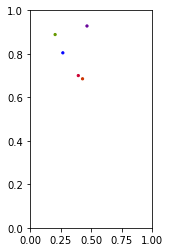

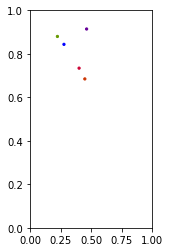

89262/89262 - 19s - loss: 4.7663 - mae: 0.1655 - mse: 0.0773 - val_loss: 3.6352 - val_mae: 0.1589 - val_mse: 0.0696
Epoch 12/50


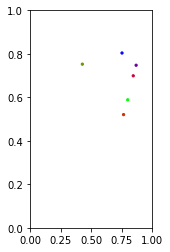

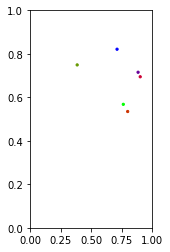

Training 24% complete. Training loss: 4.76005828175185 | Validation loss: 3.65295012803321
89262/89262 - 19s - loss: 4.7601 - mae: 0.1620 - mse: 0.0732 - val_loss: 3.6530 - val_mae: 0.1580 - val_mse: 0.0703
Epoch 13/50


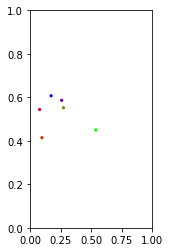

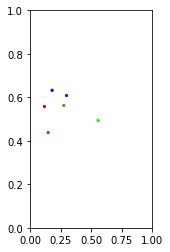

89262/89262 - 19s - loss: 4.7208 - mae: 0.1595 - mse: 0.0705 - val_loss: 3.7287 - val_mae: 0.1645 - val_mse: 0.0754
Epoch 14/50


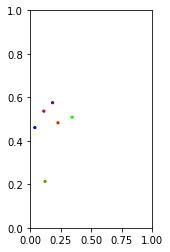

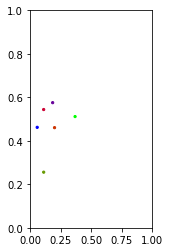

89262/89262 - 20s - loss: 4.6712 - mae: 0.1555 - mse: 0.0665 - val_loss: 3.7004 - val_mae: 0.1601 - val_mse: 0.0760
Epoch 15/50


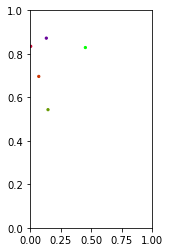

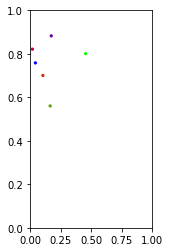

Training 30% complete. Training loss: 4.676722124159177 | Validation loss: 3.5402662128735907
89262/89262 - 19s - loss: 4.6767 - mae: 0.1535 - mse: 0.0642 - val_loss: 3.5403 - val_mae: 0.1545 - val_mse: 0.0720
Epoch 16/50


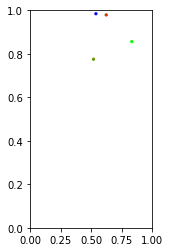

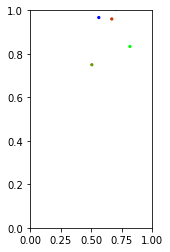

89262/89262 - 19s - loss: 4.6811 - mae: 0.1513 - mse: 0.0619 - val_loss: 3.6218 - val_mae: 0.1557 - val_mse: 0.0718
Epoch 17/50


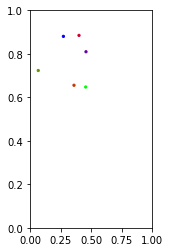

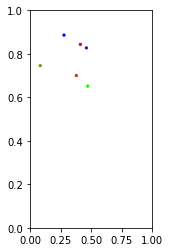

89262/89262 - 19s - loss: 4.6248 - mae: 0.1485 - mse: 0.0594 - val_loss: 3.5603 - val_mae: 0.1538 - val_mse: 0.0725
Epoch 18/50


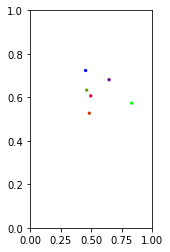

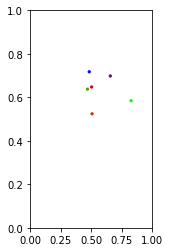

Training 36% complete. Training loss: 4.613758757193953 | Validation loss: 3.358400480032081
89262/89262 - 20s - loss: 4.6138 - mae: 0.1465 - mse: 0.0574 - val_loss: 3.3584 - val_mae: 0.1438 - val_mse: 0.0614
Epoch 19/50


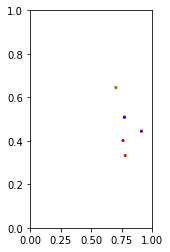

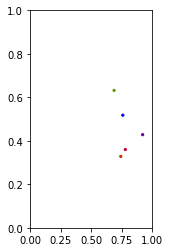

89262/89262 - 20s - loss: 4.5966 - mae: 0.1446 - mse: 0.0554 - val_loss: 3.5069 - val_mae: 0.1451 - val_mse: 0.0628
Epoch 20/50


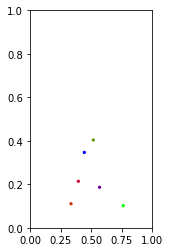

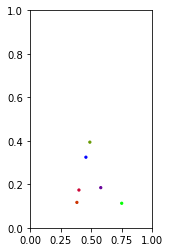

89262/89262 - 19s - loss: 4.5806 - mae: 0.1426 - mse: 0.0535 - val_loss: 3.5364 - val_mae: 0.1420 - val_mse: 0.0586
Epoch 21/50


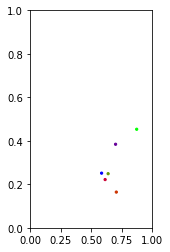

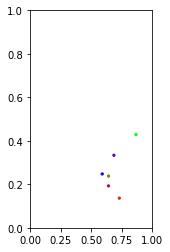

Training 42% complete. Training loss: 4.545227045460623 | Validation loss: 3.3479530131413244
89262/89262 - 19s - loss: 4.5452 - mae: 0.1409 - mse: 0.0520 - val_loss: 3.3480 - val_mae: 0.1397 - val_mse: 0.0590
Epoch 22/50


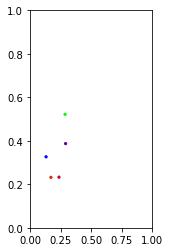

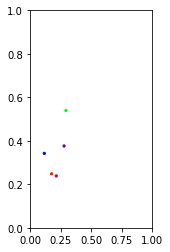

89262/89262 - 20s - loss: 4.5571 - mae: 0.1392 - mse: 0.0504 - val_loss: 3.7130 - val_mae: 0.1405 - val_mse: 0.0566
Epoch 23/50


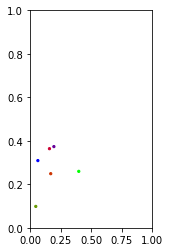

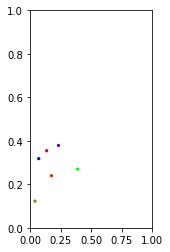

89262/89262 - 20s - loss: 4.5185 - mae: 0.1377 - mse: 0.0488 - val_loss: 3.4294 - val_mae: 0.1400 - val_mse: 0.0581
Epoch 24/50


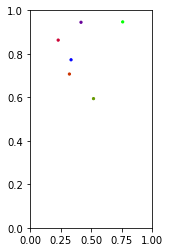

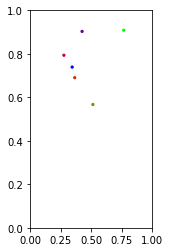

Training 48% complete. Training loss: 4.501039422161225 | Validation loss: 3.6885418974904147
89262/89262 - 19s - loss: 4.5010 - mae: 0.1363 - mse: 0.0476 - val_loss: 3.6885 - val_mae: 0.1415 - val_mse: 0.0584
Epoch 25/50


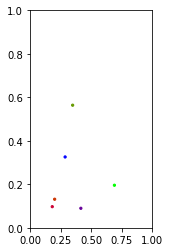

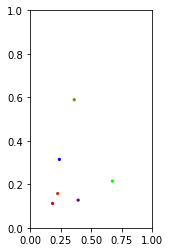

89262/89262 - 19s - loss: 4.4919 - mae: 0.1356 - mse: 0.0468 - val_loss: 3.7577 - val_mae: 0.1362 - val_mse: 0.0504
Epoch 26/50


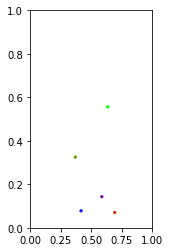

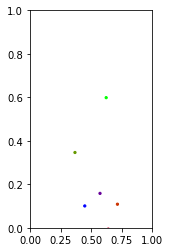

89262/89262 - 19s - loss: 4.4829 - mae: 0.1343 - mse: 0.0457 - val_loss: 3.3378 - val_mae: 0.1325 - val_mse: 0.0496
Epoch 27/50


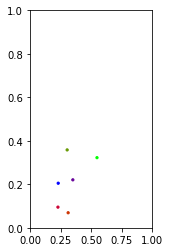

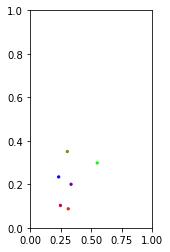

Training 54% complete. Training loss: 4.4619046399366376 | Validation loss: 3.3376441076930843
89262/89262 - 19s - loss: 4.4619 - mae: 0.1334 - mse: 0.0450 - val_loss: 3.3376 - val_mae: 0.1347 - val_mse: 0.0500
Epoch 28/50


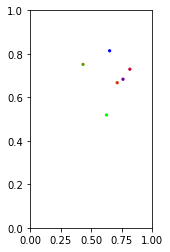

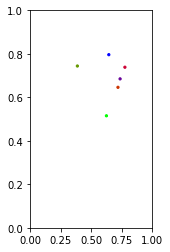

89262/89262 - 20s - loss: 4.4598 - mae: 0.1331 - mse: 0.0444 - val_loss: 3.4414 - val_mae: 0.1316 - val_mse: 0.0467
Epoch 29/50


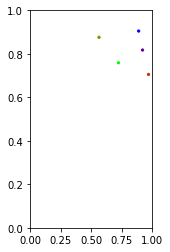

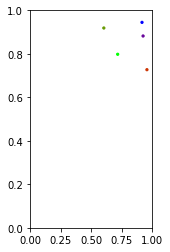

89262/89262 - 19s - loss: 4.4390 - mae: 0.1322 - mse: 0.0438 - val_loss: 3.3564 - val_mae: 0.1290 - val_mse: 0.0453
Epoch 30/50


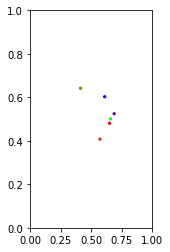

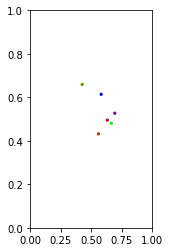

Training 60% complete. Training loss: 4.424439124386234 | Validation loss: 3.3487729738596568
89262/89262 - 19s - loss: 4.4244 - mae: 0.1312 - mse: 0.0431 - val_loss: 3.3488 - val_mae: 0.1299 - val_mse: 0.0453
Epoch 31/50


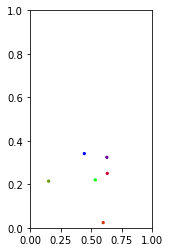

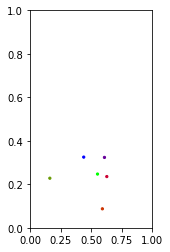

89262/89262 - 19s - loss: 4.4301 - mae: 0.1305 - mse: 0.0422 - val_loss: 3.3883 - val_mae: 0.1323 - val_mse: 0.0478
Epoch 32/50


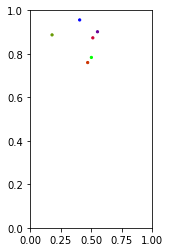

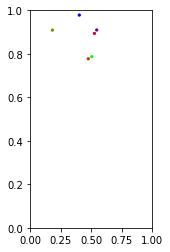

89262/89262 - 19s - loss: 4.4149 - mae: 0.1296 - mse: 0.0416 - val_loss: 3.2946 - val_mae: 0.1285 - val_mse: 0.0436
Epoch 33/50


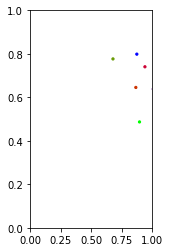

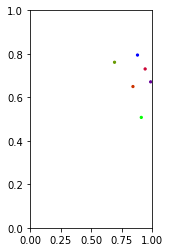

Training 66% complete. Training loss: 4.41673754360468 | Validation loss: 3.5824553822129466
89262/89262 - 19s - loss: 4.4167 - mae: 0.1298 - mse: 0.0416 - val_loss: 3.5825 - val_mae: 0.1351 - val_mse: 0.0502
Epoch 34/50


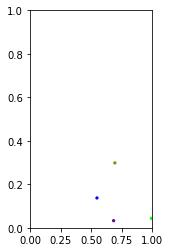

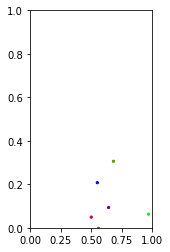

89262/89262 - 19s - loss: 4.3964 - mae: 0.1289 - mse: 0.0412 - val_loss: 4.0114 - val_mae: 0.1331 - val_mse: 0.0454
Epoch 35/50


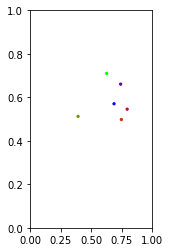

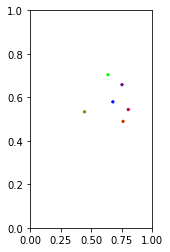

89262/89262 - 19s - loss: 4.3973 - mae: 0.1282 - mse: 0.0404 - val_loss: 4.0424 - val_mae: 0.1410 - val_mse: 0.0541
Epoch 36/50


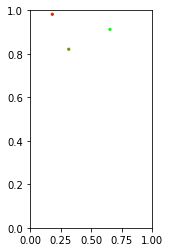

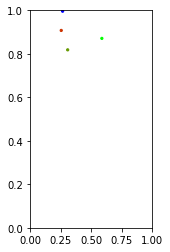

Training 72% complete. Training loss: 4.385699795008865 | Validation loss: 3.3761841736922222
89262/89262 - 19s - loss: 4.3857 - mae: 0.1277 - mse: 0.0400 - val_loss: 3.3762 - val_mae: 0.1293 - val_mse: 0.0457
Epoch 37/50


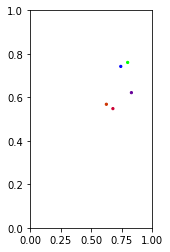

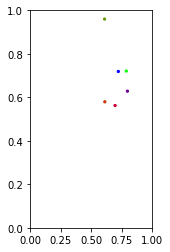

89262/89262 - 19s - loss: 4.3769 - mae: 0.1271 - mse: 0.0394 - val_loss: 3.2511 - val_mae: 0.1262 - val_mse: 0.0425
Epoch 38/50


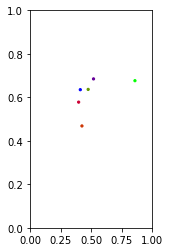

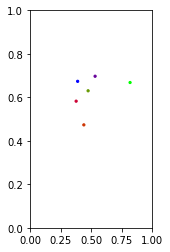

89262/89262 - 19s - loss: 4.3573 - mae: 0.1269 - mse: 0.0395 - val_loss: 3.3259 - val_mae: 0.1334 - val_mse: 0.0490
Epoch 39/50


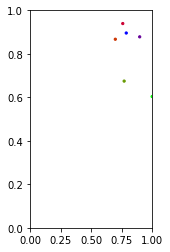

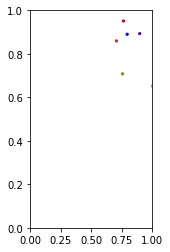

Training 78% complete. Training loss: 4.369579047765277 | Validation loss: 3.4803386996573473
89262/89262 - 20s - loss: 4.3696 - mae: 0.1264 - mse: 0.0389 - val_loss: 3.4803 - val_mae: 0.1270 - val_mse: 0.0441
Epoch 40/50


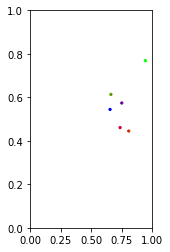

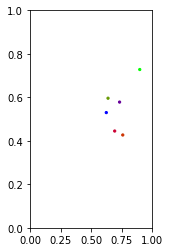

89262/89262 - 19s - loss: 4.3417 - mae: 0.1262 - mse: 0.0388 - val_loss: 3.5642 - val_mae: 0.1321 - val_mse: 0.0477
Epoch 41/50


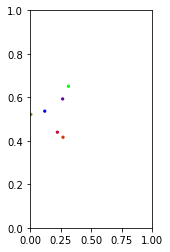

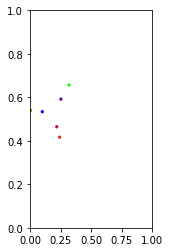

89262/89262 - 19s - loss: 4.3310 - mae: 0.1256 - mse: 0.0386 - val_loss: 3.3296 - val_mae: 0.1248 - val_mse: 0.0411
Epoch 42/50


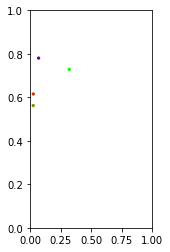

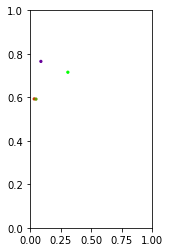

Training 84% complete. Training loss: 4.348385617664143 | Validation loss: 3.3565896787584313
89262/89262 - 19s - loss: 4.3484 - mae: 0.1252 - mse: 0.0381 - val_loss: 3.3566 - val_mae: 0.1384 - val_mse: 0.0513
Epoch 43/50


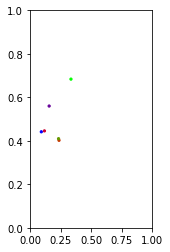

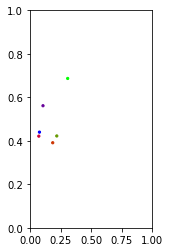

89262/89262 - 19s - loss: 4.3185 - mae: 0.1245 - mse: 0.0376 - val_loss: 3.3288 - val_mae: 0.1261 - val_mse: 0.0427
Epoch 44/50


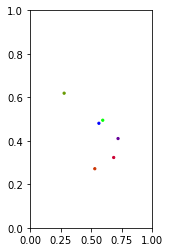

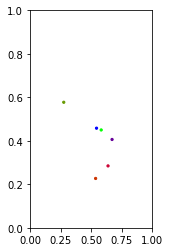

89262/89262 - 19s - loss: 4.3381 - mae: 0.1251 - mse: 0.0378 - val_loss: 3.6236 - val_mae: 0.1302 - val_mse: 0.0440
Epoch 45/50


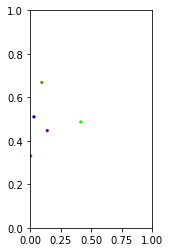

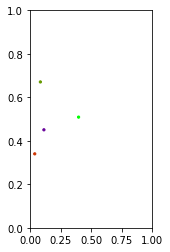

Training 90% complete. Training loss: 4.3107819989571015 | Validation loss: 3.278731854233676
89262/89262 - 19s - loss: 4.3108 - mae: 0.1242 - mse: 0.0372 - val_loss: 3.2787 - val_mae: 0.1266 - val_mse: 0.0414
Epoch 46/50


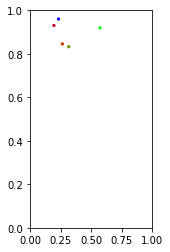

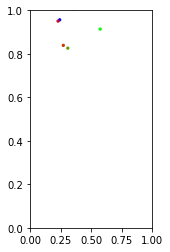

89262/89262 - 19s - loss: 4.3247 - mae: 0.1239 - mse: 0.0369 - val_loss: 3.4145 - val_mae: 0.1262 - val_mse: 0.0417
Epoch 47/50


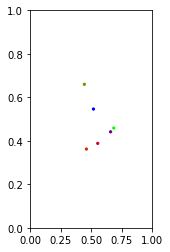

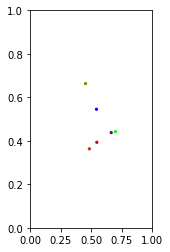

89262/89262 - 19s - loss: 4.3035 - mae: 0.1239 - mse: 0.0370 - val_loss: 3.2290 - val_mae: 0.1251 - val_mse: 0.0410
Epoch 48/50


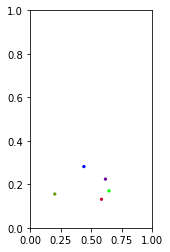

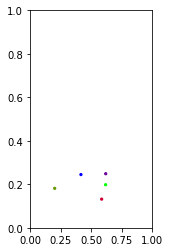

Training 96% complete. Training loss: 4.287568193325923 | Validation loss: 3.2445801047978655
89262/89262 - 19s - loss: 4.2876 - mae: 0.1231 - mse: 0.0367 - val_loss: 3.2446 - val_mae: 0.1246 - val_mse: 0.0398
Epoch 49/50


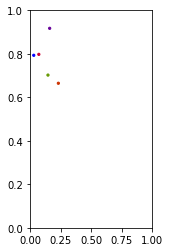

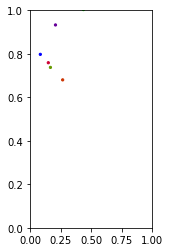

89262/89262 - 19s - loss: 4.3002 - mae: 0.1236 - mse: 0.0368 - val_loss: 3.4332 - val_mae: 0.1274 - val_mse: 0.0412
Epoch 50/50


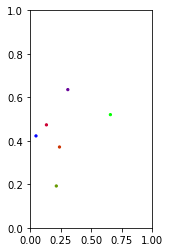

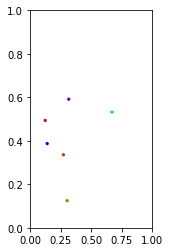

89262/89262 - 19s - loss: 4.2850 - mae: 0.1227 - mse: 0.0363 - val_loss: 3.7101 - val_mae: 0.1260 - val_mse: 0.0406


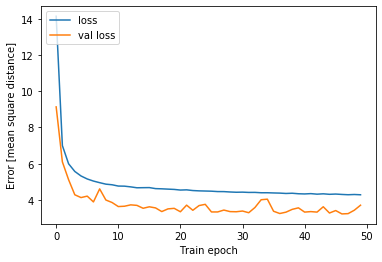

In [15]:
import tensorflow as tf
import datetime, os

# tensorabord callbacks
logdir = os.path.join("logs3", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# uncomment this to start tensorboard now (before training, if you want)
# %tensorboard --logdir logs3

# Everything is now in place to train.
EPOCHS = 50
pt = ProgressTracker(EPOCHS)


history = model.fit(
    data,
    target,
    epochs=EPOCHS,
    validation_data=(data_test, target_test),
    verbose=2,
    callbacks=[tensorboard_callback, pt]

    )

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val loss'], loc='upper left')
plt.xlabel('Train epoch')
_ = plt.ylabel('Error [mean square distance]')

In [0]:
# save it, convert it to "js" and test on yourself :)

model.save('model.h5')